# Single Agreement Experiments (PVE)

In [140]:
import pickle
from re import X
from scipy.optimize import minimize
import math
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import random
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
# from uwTOPSIS.uwTOPSIS import *
import geopandas as gpd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display
from sklearn.preprocessing import normalize
from functools import partial
import time
from joblib import Parallel, delayed
from multiprocessing import Pool
import seaborn as sns
from uwTOPSIS.uwTOPSIS import *

In [141]:
# FUNCTIONS DATA PREPARATION

def concat_columns(row):
    return np.array(row[['kosten', 'land', 'leiding', 'samen', 'zelf']])

def divide_by_sum(arr):
    return arr / arr.sum()

In [142]:
file_path = "Datasets/VO_matrices.pkl"

with open(file_path, 'rb') as f:
    data = pickle.load(f)




for key, df in data.items():
    data[key] = df.values.transpose()

for key, df in data.items():
    data[key] = df.flatten()

df_x0 = pd.DataFrame(list(data.items()), columns=['Keys', 'Values'])

df_x0['x0'] = df_x0['Values']

df_x0.drop(columns=['Values'], inplace=True)


df_x0['id'] = df_x0['Keys']
df_x0.drop(columns=['Keys'], inplace=True)

file_path = "Datasets/complete_rankings.csv"

df_omega = pd.read_csv(file_path)


df_omega['omega'] = df_omega.apply(concat_columns, axis=1)

df_omega.drop(columns=['kosten', 'land', 'leiding', 'samen', 'zelf'], inplace=True)

df_omega['omega_weights'] = df_omega['omega'].apply(divide_by_sum)

df_omega.drop(columns=['omega'], inplace=True)


df = pd.merge(df_x0, df_omega, on='id')
names = np.stack(df['id'].values)
x0_values = df['x0'].values
omega_values = df['omega_weights'].values

x0 = np.stack(x0_values)
omega = np.stack(omega_values)

In [143]:
### FUNCIONES DE UTILIDAD ######
def util_i(x, x0i, wi):
  utilid = 0
  V = len(wi) # Número de criterios
  AV = len(x) # Criterios por acciones
  for j in range(0,AV):
    utilid += -((x[j] - x0i[j]) / (1 - wi[j%V]))**2
  return utilid

def global_utility(x, x0, w):
  n = len(x0) # Este error, antes estaba poniendo x, lo suyo es poner x0
  gl_ut = 0
  for i in range(0,n):
    gl_ut += util_i(x,x0[i],w[i])
  return gl_ut/len(x0)

# 1. Acuerdos Matrices X

## 1.1. Consenso+gradiente

Veamos cual es la matriz de decisión X obtenida con nuestro método, partiendo de la red conectando todos con todos:

In [144]:
file_path = "break_X_PVE_Single_Agreement_TodosxTodos.pickle"

with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [145]:
data[:,499,:][0]

array([0.49187635, 0.49635276, 0.865742  , 0.5352781 , 0.55358594,
       0.50828017, 0.48439636, 0.59315826, 0.64814597, 0.7948165 ,
       0.90362884, 0.        , 0.89364125, 0.88384441, 0.        ,
       0.66281199, 0.89676517, 0.        , 0.        , 0.        ,
       0.9215026 , 0.8769075 , 0.        , 0.        , 0.90875703,
       0.90170575, 0.90504292, 0.        , 0.93305723, 0.        ])

In [146]:
print("Utilidad global de nuestra solución: "+str(global_utility(data[:,499,:][0], x0, omega)))

Utilidad global de nuestra solución: -5.441922283219222


Vemos la distrubución de las utilidades individuales al evaluarlas con esta matrix obtenida:

In [147]:
max(utility_values_decentralized)

-2.8875777968436855

In [148]:
min(utility_values_decentralized)

-16.17860996828327

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\3507376237.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


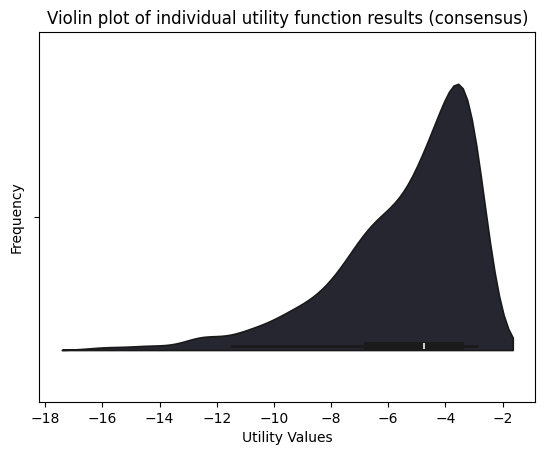

In [149]:
n = len(data) # Número de agentes.

utility_values_decentralized = [util_i(data[:,499,:][0], x0[i], omega[i]) for i in range(n)]

df = pd.DataFrame({'i': range(n), 'utility_value': utility_values_decentralized})

fig, ax = plt.subplots()


sns.violinplot(x='utility_value', data=df, color="blue", 
               hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)


ax.legend_ = None

plt.title('Violin plot of individual utility function results (consensus)')
plt.xlabel('Utility Values')
plt.ylabel('Frequency')

plt.show()

## 1.2. Solución paper $\ell_p$-regression con p=2 (mean)

In [150]:
VO_p2 = np.array([0.49771689, 0.5       , 0.86872146, 0.54223744, 0.55479452,
       0.51141553, 0.48972603, 0.59246575, 0.65296804, 0.7956621 ,
       0.90525114, 0.        , 0.89383562, 0.88584475, 0.        ,
       0.66780822, 0.89954338, 0.        , 0.        , 0.        ,
       0.92237443, 0.88013699, 0.        , 0.        , 0.90639269,
       0.90182648, 0.90639269, 0.        , 0.93378995, 0.        ])

In [151]:
print("Utilidad global V0_p2: "+str(global_utility(VO_p2, x0, omega)))

Utilidad global V0_p2: -5.445537504889013


C:\Users\artur\AppData\Local\Temp\ipykernel_32000\3571612626.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


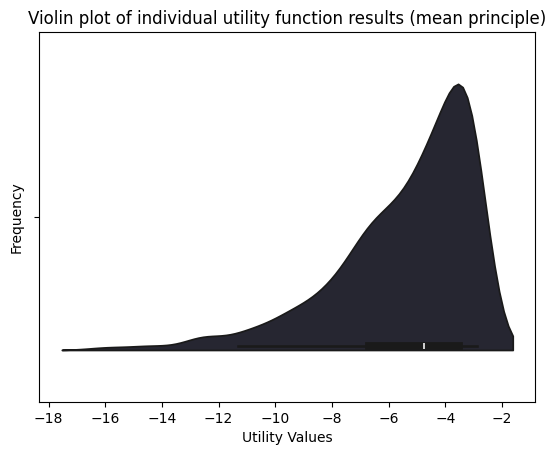

In [152]:
utility_values = [util_i(VO_p2, x0[i], omega[i]) for i in range(n)]

df = pd.DataFrame({'i': range(n), 'utility_value': utility_values})

fig, ax = plt.subplots()

sns.violinplot(x='utility_value', data=df, color="blue", 
               hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)

ax.legend_ = None

plt.title('Violin plot of individual utility function results (mean principle)')
plt.xlabel('Utility Values')
plt.ylabel('Frequency')

plt.show()

## 1.3. Solución paper $\ell_p$-regression con p=1 (utilitarian)

Se obtiene la matrix nula como solución:

In [153]:
VO_p1 = np.array([0., 0.5, 1., 1., 1.,
              1., 0.,1., 1., 1. ,
              1., 0., 1., 1., 0.,
              1., 1., 0., 0., 0.,
              1., 1., 0., 0., 1.,
              1., 1., 0.,1., 0.])

In [154]:
print("Utilidad global V0_p1: "+str(global_utility(VO_p1, x0, omega)))

Utilidad global V0_p1: -8.201804454403726


In [155]:
max(utility_values)

-2.8802347267212935

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\4038818922.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


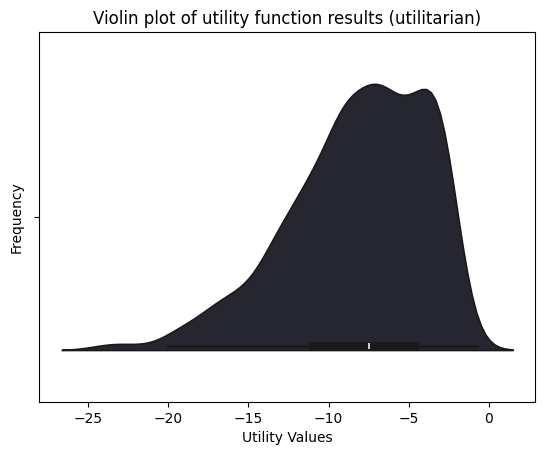

In [156]:
utility_values_utilitarian = [util_i(VO_p1, x0[i], omega[i]) for i in range(n)]

df = pd.DataFrame({'i': range(n), 'utility_value': utility_values_utilitarian})

fig, ax = plt.subplots()

sns.violinplot(x='utility_value', data=df, color="blue", 
               hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)

ax.legend_ = None

plt.title('Violin plot of utility function results (utilitarian)')
plt.xlabel('Utility Values')
plt.ylabel('Frequency')

plt.show()

## 1.4. Solución paper $\ell_p$-regression p=$\infty$ (egalitarian)

In [157]:
V0_inf = np.array([0.5, 0.5, 0.5, 0.5, 0.5,
              0.5, 0.5, 0.5, 0.5, 0.5,
              0.5, 0., 0.5, 0.5, 0.,
              0.5, 0.5, 0., 0., 0.,
              0.5, 0.5, 0., 0., 0.5,
              0.5, 0.5, 0., 0.5, 0.])

In [158]:
print("Utilidad global V0_inf: "+str(global_utility(V0_inf, x0, omega)))

Utilidad global V0_inf: -8.378299636540463


In [159]:
np.min(utility_values)

-16.277030240165107

In [160]:
max(utility_values)

-2.8802347267212935

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\2705553947.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


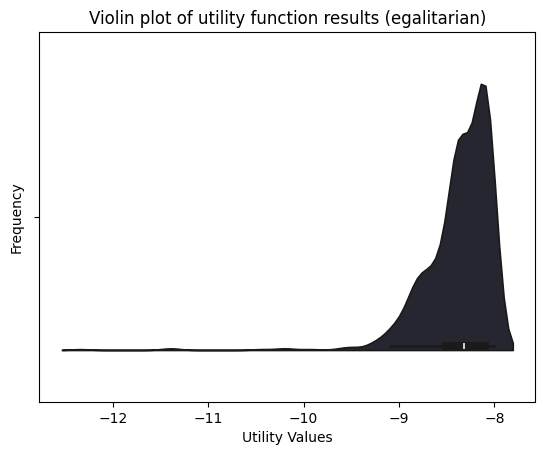

In [161]:
utility_values_egalitarian = [util_i(V0_inf, x0[i], omega[i]) for i in range(n)]

df = pd.DataFrame({'i': range(n), 'utility_value': utility_values_egalitarian})

fig, ax = plt.subplots()

sns.violinplot(x='utility_value', data=df, color="blue", 
               hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)

ax.legend_ = None

plt.title('Violin plot of utility function results (egalitarian)')
plt.xlabel('Utility Values')
plt.ylabel('Frequency')

plt.show()

In [166]:
np.mean(utility_values_decentralized)

-5.441922283219225

In [167]:
np.mean(utility_values_egalitarian)

-8.37829963654046

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\4287281631.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Individual Utility', data=df, palette='pastel')  # Set1 is just one color palette


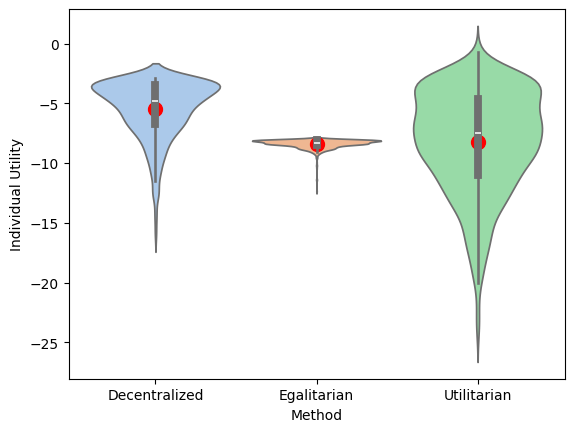

In [177]:
data = utility_values_decentralized + utility_values_egalitarian + utility_values_utilitarian
groups = (['Decentralized'] * len(utility_values_decentralized)) + (['Egalitarian'] * len(utility_values_egalitarian)) + (['Utilitarian'] * len(utility_values_utilitarian))


import pandas as pd
df = pd.DataFrame({'Individual Utility': data, 'Method': groups})

sns.violinplot(x='Method', y='Individual Utility', data=df, palette='pastel') 


means = df.groupby('Method')['Individual Utility'].mean()
methods = ['Decentralized', 'Egalitarian', 'Utilitarian']
colors = ['red'] * len(methods)  # red points

ax = plt.gca()

for i, method in enumerate(methods):
    plt.scatter(i, means[method], color='red', s=100)  # s is the size of the dot

plt.show()

## Conclusiones


Como era de esperar, la utilidad global máxima se alcanza en el punto calculado con nuestro modelo.

Respecto a las distribuciones de las utilidades individuales en cada caso, vemos como en el caso de la solución egualitaria propuesta en el artículo, la mayoría de los agentes tienen una utilidad similar para la matriz obtenida en este caso. En el caso de la solución obtenida en el consenso, vemos como hay bastantes agentes con una utilidad individual elevada para esta solución, aunque la distribución no está tan sesgada hacia la derecha como en el caso de la solución egualitaria.

Para el resto de soluciones (mean principle y utilitarian), las distrubuciones de las utilidades individuales obtenidas son notablemente peores que en los otros dos casos. Utilidades menores en general y mucha más dispersión.

# 2. Acuerdos Pesos $\omega$

## 2.1. Consenso+gradiente

In [178]:
file_path = "break_w_PVE_Single_Agreement_TodosxTodos.pickle"

with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [179]:
data[:,499,:][0]

array([0.14826686, 0.17555519, 0.2041415 , 0.23221385, 0.2398226 ])

In [180]:
print("Utilidad global de nuestra solución: "+str(global_utility(data[:,499,:][0], omega, omega)))

Utilidad global de nuestra solución: -0.06446889112612848


In [181]:
min(utility_values_decentralized)

-16.17860996828327

In [182]:
max(utility_values_decentralized)

-2.8875777968436855

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\2954659366.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


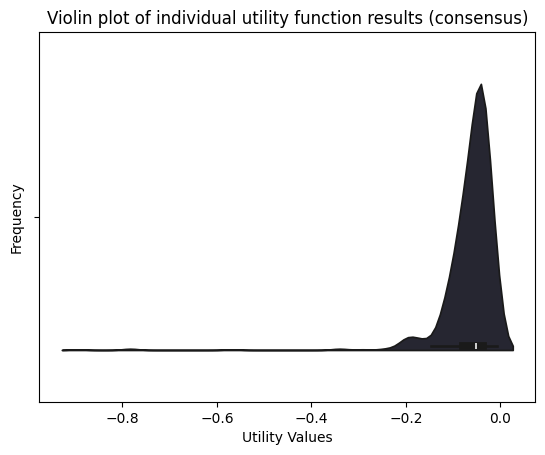

In [183]:
n = len(data) # Número de agentes.

utility_values_decentralized = [util_i(data[:,499,:][0], omega[i], omega[i]) for i in range(n)]

df = pd.DataFrame({'i': range(n), 'utility_value': utility_values_decentralized})

fig, ax = plt.subplots()

sns.violinplot(x='utility_value', data=df, color="blue", 
               hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)

ax.legend_ = None

plt.title('Violin plot of individual utility function results (consensus)')
plt.xlabel('Utility Values')
plt.ylabel('Frequency')

plt.show()

## 2.2. Probamos con los rankings obtenidon lp regression con distintos p.

In [184]:
# Define arrays
p1 = np.array([0.142, 0.1538, 0.2143, 0.2308, 0.25])
p2 = np.array([0.14900858, 0.17521744, 0.20411548, 0.23268621, 0.23897229])

inf = np.array([0.3111, 0.3111, 0.2023, 0.3111, 0.2338])

p_combined = np.array([p1,p2,inf])

p=[1,2,'inf']

In [185]:
min(utility_values_utilitarian)

-24.421602156584672

In [99]:
max(utility_values_utilitarian)

-0.007255513599999998

In [103]:
min(utility_values_egalitarian)

-0.43334134671875013

In [104]:
max(utility_values_egalitarian)

-0.04324368726391184

In [188]:
utility_values_utilitarian = [util_i(p1, omega[i], omega[i]) for i in range(n)]

In [189]:
utility_values_egalitarian = [util_i(inf, omega[i], omega[i]) for i in range(n)]

In [70]:
for i in range(0,len(p)):
    print("Utilidad global p="+str(p[i])+": "+str(global_utility(p_combined[i], omega, omega)))

Utilidad global p=1: -0.0660833969342689
Utilidad global p=2: -0.06449443308169896
Utilidad global p=inf: -0.11997924032761467


C:\Users\artur\AppData\Local\Temp\ipykernel_32000\2827304262.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


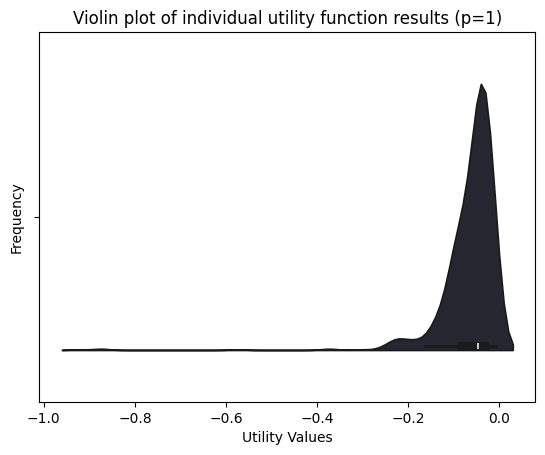

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\2827304262.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


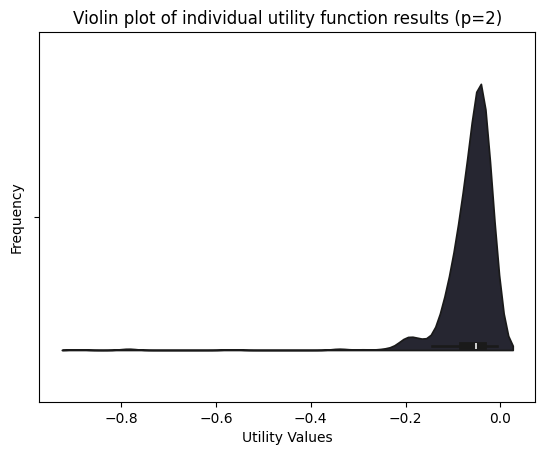

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\2827304262.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


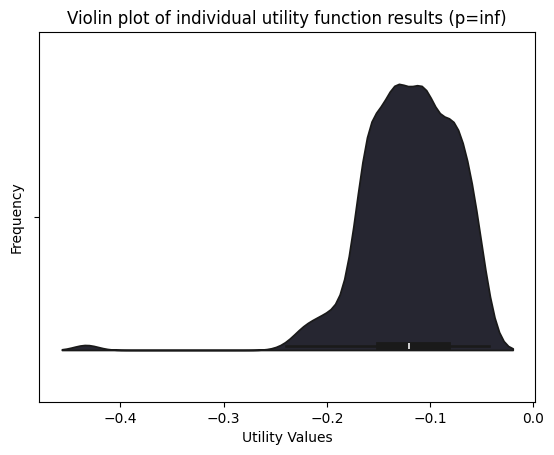

In [186]:

for j in range(0, len(p)):

    utility_values = [util_i(p_combined[j], omega[i], omega[i]) for i in range(n)]

    df = pd.DataFrame({'i': range(n), 'utility_value': utility_values})

    fig, ax = plt.subplots()

    sns.violinplot(x='utility_value', data=df, color="blue", 
                   hue=True, split=True, hue_order=[True, False],gap=.1,ax=ax)

    ax.legend_ = None

    plt.title('Violin plot of individual utility function results (p='+str(p[j])+')')
    plt.xlabel('Utility Values')
    plt.ylabel('Frequency')

    plt.show()

C:\Users\artur\AppData\Local\Temp\ipykernel_32000\3355520939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Individual Utility', data=df, palette='pastel')  # Set1 is just one color palette


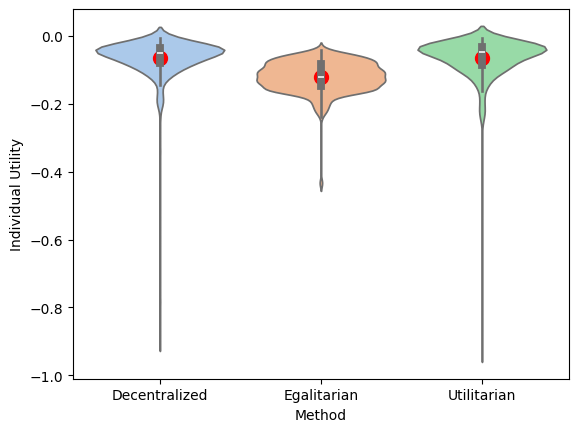

In [193]:
data = utility_values_decentralized + utility_values_egalitarian + utility_values_utilitarian
groups = (['Decentralized'] * len(utility_values_decentralized)) + (['Egalitarian'] * len(utility_values_egalitarian)) + (['Utilitarian'] * len(utility_values_utilitarian))

import pandas as pd
df = pd.DataFrame({'Individual Utility': data, 'Method': groups})

sns.violinplot(x='Method', y='Individual Utility', data=df, palette='pastel') 


means = df.groupby('Method')['Individual Utility'].mean()
methods = ['Decentralized', 'Egalitarian', 'Utilitarian']
colors = ['red'] * len(methods) 

ax = plt.gca()

for i, method in enumerate(methods):
    plt.scatter(i, means[method], color='red', s=100)  # s is the size of the dot

plt.show()

### Conclusiones

En este caso, la distribución obtenida con nuestro modelo es más parecida a la utilitaria. En la solucion egualitaria, el rando de utilidades es menor, teniendo todos los agentes una utilidad más similar, aunque no hay agentes con una utilidad tan alta como con los otros dos métodos.

### TOPSIS CON CADA SOLUCIÓN


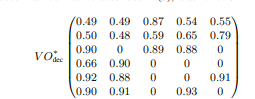

In [194]:
# Decenrtralized
VO_dec = pd.DataFrame({
    "c1": [0.49, 0.50, 0.90, 0.66, 0.92, 0.90],
    "c2": [0.49, 0.48, 0.00, 0.90, 0.88, 0.91],
    "c3": [0.87, 0.59, 0.89, 0.00, 0.00, 0.00],
    "c4": [0.54, 0.65, 0.88, 0.00, 0.00, 0.93],
    "c5": [0.55, 0.79, 0.00, 0.00, 0.91, 0.00]
})

weights_decentralized =  np.array([0.15, 0.18, 0.20 , 0.23, 0.24])

directions = ["max", "max", "max", "max", "max"]
norm = "euclidean"
p = 2

TOPSIS(VO_dec, directions, weights_decentralized, norm, p)

array([0.64238979, 0.69929126, 0.49538345, 0.27628571, 0.50327584,
       0.45202168])

In [196]:
# Utilitarian

VO_p1 = pd.DataFrame({
    "c1": [0, 1, 1, 1, 1, 1],
    "c2": [0.5, 0, 0, 1, 1, 1],
    "c3": [1, 1, 1, 0.00, 0.00, 0.00],
    "c4": [1, 1, 1, 0.00, 0.00, 1],
    "c5": [1, 1, 0.00, 0.00, 1, 0.00]
})


p1 = np.array([0.142, 0.1538, 0.2143, 0.2308, 0.25])

TOPSIS(VO_p1, directions, p1, norm, p)

array([0.74747858, 0.73052997, 0.51873005, 0.32351238, 0.51448934,
       0.45220295])

In [ ]:
# Egalitarian

V0_inf = pd.DataFrame({
    "c1": [0, 1, 1, 1, 1, 1],
    "c2": [0.5, 0, 0, 1, 1, 1],
    "c3": [1, 1, 1, 0.00, 0.00, 0.00],
    "c4": [1, 1, 1, 0.00, 0.00, 1],
    "c5": [1, 1, 0.00, 0.00, 1, 0.00]
})

inf = np.array([0.3111, 0.3111, 0.2023, 0.3111, 0.2338])

TOPSIS(V0_inf, directions, inf, norm, p)